# Modeling

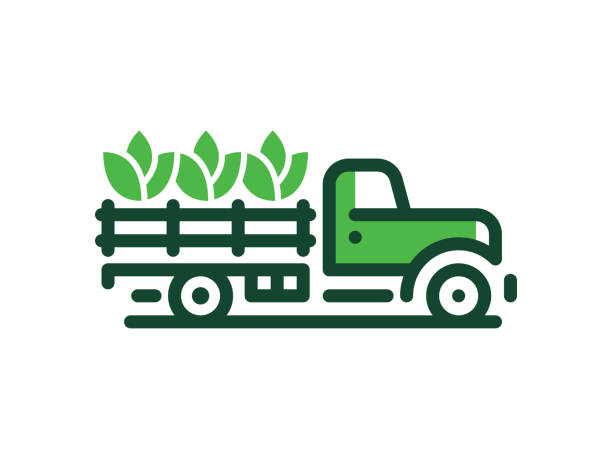

## Overview

The Instacart dataset contains historical order information, including product details, user behavior, and order characteristics. My goal is to use a predictive model to analyze which features influence a customer's likelihood to reorder organic products. By examining the model's coefficients, I can gain insights into which features have the most significant impact on the prediction.

***
## Results

I started with a decision tree to understand the relationship between features but due to my imbalanced data I transitioned to XGBoost for improved predictive power. Lastly I utilized logistic regression to interpret and quantify the impact of features.

Because of the imbalance in my data I not only wanted to identify positive instances but wanted to minimize instances where my model predicted a customer will reorder organic products but they do not. Leading to incorrect allocation of resources towards customers who are not likely to reorder organic products. I also wanted to minimize instances where my model suggested a customer does not reorder organic products but they do. Leading to missed opportunities to promote organic products to customers who are actually interested in them.

In a pursuit to find a balance between these two instances I used an F1-Score as my metric.

My XGBoost Model had an F1-Score of 84% which struck a balance between precision and recall.

***
## Data Preperation

In [1]:
#imports
import pandas as pd
import numpy as np
import scipy
import os
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import xgboost as xgb


import warnings
warnings.filterwarnings('ignore')

In [2]:
#read in files
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')

In [3]:
dataframes = ['orders', 'order_products_prior', 'products']

for df_name in dataframes:
    df = globals()[df_name]
    print(f"DataFrame: {df_name}")
    print("Number of rows:", len(df))
    display(df.head())
    print("Info:")
    display(df.info())
    print("Describe:")
    display(df.describe())
    print("=" * 40)

DataFrame: orders
Number of rows: 3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


None

Describe:


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


DataFrame: order_products_prior
Number of rows: 32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


None

Describe:


,order_id,product_id,add_to_cart_order,reordered
count,3.243449e+07,3.243449e+07,3.243449e+07,3.243449e+07
mean,1.710749e+06,2.557634e+04,8.351076e+00,5.896975e-01
std,9.873007e+05,1.409669e+04,7.126671e+00,4.918886e-01
min,2.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,8.559430e+05,1.353000e+04,3.000000e+00,0.000000e+00
50%,1.711048e+06,2.525600e+04,6.000000e+00,1.000000e+00
75%,2.565514e+06,3.793500e+04,1.100000e+01,1.000000e+00
max,3.421083e+06,4.968800e+04,1.450000e+02,1.000000e+00


DataFrame: products
Number of rows: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


None

Describe:


,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


In [4]:
#capping the days since to 29 to avoid outliers
orders = orders.loc[orders['days_since_prior_order'] <= 29]

In [5]:
#creating a column of if a product is organic or not
products['organic'] = products['product_name'].str.lower().str.contains('organic').astype(int)

In [6]:
#creating an organic produce column
products['organic_produce'] = np.where((products['organic'] == 1) & (products['department_id'] == 4), 1, 0)

In [7]:
#merging files together
df = products.merge(order_products_prior,on='product_id', how='inner')
df = pd.merge(df, orders, on='order_id', how='inner')

In [8]:
#creating an organic dataframe and dropping unused and categorical columns for modeling
organic_mod= df.loc[df['organic'] == 1]
organic_mod = organic_mod.drop(['organic','product_name','eval_set'], axis=1)

***
## Feature Engineering

The features used to build our models are:

- Order_id
- Order_number
- Average_days_between_orders
- Basket_size
- Aisle
- Department
- Product
- User_id
- Order_hour_of_day
- Order_dow(day of week)
- Average Product Position in cart
- Average days since a product was ordered

In [9]:
#Adding column average days between a users orders using days_since_prior_order
organic_mod['avg_days_btn_orders'] = organic_mod.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
organic_mod['avg_days_btn_orders'] = organic_mod['avg_days_btn_orders'].replace(np.nan, 1)

In [10]:
#adding a column 'basket_size' for the number of products in each order
organic_mod['basket_size'] = organic_mod.groupby('order_id')['product_id'].transform('count')

In [11]:
#adding a column 'avg_prod_cart_position' for the average placement of a product in a user cart
organic_mod['avg_prod_position'] = organic_mod.groupby('product_id')['add_to_cart_order'].transform('mean')

In [12]:
#adding a column for the average days since a product was ordered
organic_mod['avg_days_since_last_order_product'] = organic_mod.groupby('product_id')['days_since_prior_order'].transform('mean')

Checking for any missing data before splitting the data

In [13]:
# Calculate the percentage of missing values in each column
missing_percentage = (organic_mod.isnull().sum() / len(organic_mod)) * 100
# Create a new DataFrame to store the missing percentage for each column
missing_data = pd.DataFrame({'Column': organic_mod.columns, 'MissingPercentage': missing_percentage})
# Print the missing percentage for each column
missing_data

,Column,MissingPercentage
product_id,product_id,0.0
aisle_id,aisle_id,0.0
department_id,department_id,0.0
organic_produce,organic_produce,0.0
order_id,order_id,0.0
add_to_cart_order,add_to_cart_order,0.0
reordered,reordered,0.0
user_id,user_id,0.0
order_number,order_number,0.0
order_dow,order_dow,0.0


There no missing values and all columns are numeric

In [14]:
#checking final features
organic_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8786162 entries, 7 to 27286095
Data columns (total 16 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   product_id                         int64  
 1   aisle_id                           int64  
 2   department_id                      int64  
 3   organic_produce                    int32  
 4   order_id                           int64  
 5   add_to_cart_order                  int64  
 6   reordered                          int64  
 7   user_id                            int64  
 8   order_number                       int64  
 9   order_dow                          int64  
 10  order_hour_of_day                  int64  
 11  days_since_prior_order             float64
 12  avg_days_btn_orders                float32
 13  basket_size                        int64  
 14  avg_prod_position                  float64
 15  avg_days_since_last_order_product  float64
dtypes: float32(1), fl

** **
# Modeling

### Train Test Split

I am using reordered as my target variable and have 15 features

In [15]:
#checking class balance
organic_mod['reordered'].value_counts(normalize=True)

1    0.692927
0    0.307073
Name: reordered, dtype: float64

In [16]:
# Separate features and target
X = organic_mod.drop('reordered', axis=1) #data
y = organic_mod['reordered'] #target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

For my models I will be using The F1-score metric because it is a weighted average of precision and recall. It is a good measure of overall performance, especially when the classes are imbalanced such as mine

** **
## Decision Tree Classifier (Baseline)

In [17]:
#instantiate a DecisionTreeClassifier
tree_model_base = DecisionTreeClassifier(random_state=42)

#fit the model on the train data
tree_model_base.fit(X_train, y_train)

#make predictions
y_pred_base = tree_model_base.predict(X_test)
train_pred_base = tree_model_base.predict(X_train)

base_cm = confusion_matrix(y_test, y_pred_base)

#print f1_scores
print("Train F1-Score:", f1_score(y_train, train_pred_base))
print("Test F1-Score:", f1_score(y_test, y_pred_base))
# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_base))
# print confusion matrix
print("Confusion Matrix:")
print(base_cm)

Train F1-Score: 1.0
Test F1-Score: 0.7579013406818329
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.48      0.47    539599
           1       0.76      0.75      0.76   1217634

    accuracy                           0.67   1757233
   macro avg       0.61      0.61      0.61   1757233
weighted avg       0.67      0.67      0.67   1757233

Confusion Matrix:
[[256494 283105]
 [301916 915718]]


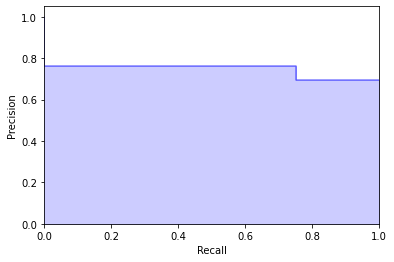

In [19]:
#Calculate predicted probabilities 
y_prob_base = tree_model_base.predict_proba(X_test)[:, 1]
train_prob_base = tree_model_base.predict_proba(X_train)[:, 1]

#Calculate the precision-recall curve and average precision score:
precision, recall, _ = precision_recall_curve(y_test, y_prob_base)

#Plot the precision-recall curve:
plt.figure()
plt.step(recall, precision, color='b', alpha=0.5, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

The baseline decision tree classifier achieved a **train F1-score** of **1.0** and a **test F1-score** of **0.75**.

Overall, the decision tree classifier is performing well on the training data, but it is not generalizing well to the test data and is likely due to overfitting. The confusion matrix shows my model is misclassifying a significant number of negative instances as positive instances.

I will run another Decision Tree Classifier this time tuning it with a max depth of 7.

### Decision Tree with max depth of 7

In [20]:
#instantiate a DecisionTreeClassifier with a max_depth of 7
tree_model = DecisionTreeClassifier(max_depth=7,random_state=42)

#fit the model on the train data
tree_model.fit(X_train, y_train)

#make predictions on test and train data
y_pred = tree_model.predict(X_test)
tree_train_pred = tree_model.predict(X_train)

cm = confusion_matrix(y_test,y_pred)

#print f1 scores
print("Train F1-Score:", f1_score(y_train, tree_train_pred))
print("Test F1-Score:", f1_score(y_test, y_pred))
# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
# print confusion matrix
print("Confusion Matrix:")
print(cm)

Train F1-Score: 0.8280921467339363
Test F1-Score: 0.8280138278051206
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.39      0.48    539599
           1       0.77      0.90      0.83   1217634

    accuracy                           0.74   1757233
   macro avg       0.70      0.65      0.66   1757233
weighted avg       0.73      0.74      0.72   1757233

Confusion Matrix:
[[ 212983  326616]
 [ 126614 1091020]]


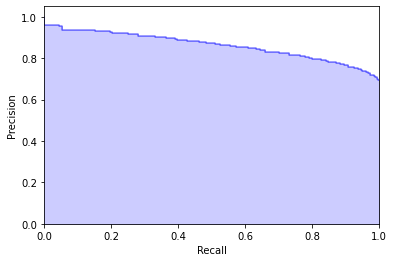

In [21]:
#Calculate predicted probabilities 
y_prob = tree_model.predict_proba(X_test)[:, 1]
train_prob = tree_model.predict_proba(X_train)[:, 1]

#Calculate the precision-recall curve and average precision score:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

#Plot the precision-recall curve:
plt.figure()
plt.step(recall, precision, color='b', alpha=0.5, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

Lets compare the tuned decision tree and the baseline

The decision tree with a max depth of 7 is performing well on both the training and test data

- **0.8281**: The F1-score on the training data  is lower than the perfect 1.0 on the base. This indicates that the model is still capturing a good portion of the training data's positive instances.

- **0.8280**: The F1-score on the test data is indicating good generalization to new data.

The decision tree is performing better than the baseline model in both precision and recall for both classes. The F1-scores for both classes have improved and maintained a balanced performance, indicating better generalization to new data.The confusion matrix on my second model also shows fewer misclassifications, particularly for class 0.

My decision tree with a max_depth of 7 seems to be an improvement over my baseline model, as it achieves higher precision, recall, and F1-scores on both classes while maintaining good generalization to new data.

***
## XGBoost Classifier

I decided on using an XGBoost Classifier as my final model because it combines multiple decision trees to improve the performance. It is designed to handle imbalanced data which applies for my dataset.

In [24]:
# Instatiate a XGB model
final_model = xgb.XGBClassifier(random_state=42)

# Train the model
final_model.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test,y_pred)

#print f1 scores
print("Test F1-Score:", f1_score(y_test, y_pred))
# print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
# print confusion matrix
print("Confusion Matrix:")
print(cm)

[11:57:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\gbm\gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
Test F1-Score: 0.8389293717162665
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.44      0.53    539599
           1       0.78      0.90      0.84   1217634

    accuracy                           0.76   1757233
   macro avg       0.72      0.67      0.68   1757233
weighted avg       0.75      0.76      0.74   1757233

Confusion Matrix:
[[ 235171  304428]
 [ 117871 1099763]]


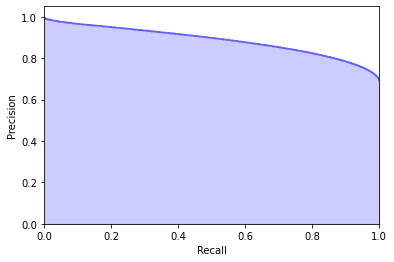

In [26]:
#Calculate predicted probabilities 
y_prob = final_model.predict_proba(X_test)[:, 1]
train_prob = final_model.predict_proba(X_train)[:, 1]

#Calculate the precision-recall curve and average precision score:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

#Plot the precision-recall curve:
plt.figure()
plt.step(recall, precision, color='b', alpha=0.5, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

The XGBoost model has the best overall performance with the highest F1-Score, balanced precision and recall. This indicates that the XGBoost model is most effective in correctly classifying instances in both classes while keeping a balance between precision and recall

Next lets check the feature imporantance from the XGBoost model

In [27]:
# Get feature importances
importances = final_model.feature_importances_

# Get feature names
feature_names = X_train.columns.tolist()

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

importance_df

,Feature,Importance
7,order_number,0.468421
13,avg_prod_position,0.184234
5,add_to_cart_order,0.094996
12,basket_size,0.055486
2,department_id,0.050896
10,days_since_prior_order,0.032285
3,organic_produce,0.027546
14,avg_days_since_last_order_product,0.026864
1,aisle_id,0.026461
0,product_id,0.012322


Now I will take those top 10 features and run them through a logistic regression to get coefficents and odds ratios

***
## Logistic Regression - for feature interpretability

In [28]:
# Select the top features from my xgb model
features = [
    'order_number',
    'avg_prod_position',
    'add_to_cart_order',
    'department_id',
    'basket_size',
    'organic_produce',
    'avg_days_since_last_order_product',
    'days_since_prior_order',
    'product_id'
]

# Create a new DataFrame with only the selected features
X_train_xgb = X_train[features]
X_test_xgb = X_test[features]

# Instantiate the LogisticRegression model
logreg_model = LogisticRegression(penalty='none',random_state=42)

logreg_model.fit(X_train_xgb, y_train)

# Fit the model on the selected features
logreg_test_pred = logreg_model.predict(X_test_xgb)

cm = confusion_matrix(y_test,logreg_test_pred)

print("Test F1-Score:", f1_score(y_test, logreg_test_pred))

# Display classification report
print("Classification Report:\n", classification_report(y_test, logreg_test_pred))
# print confusion matrix
print("Confusion Matrix:")
print(cm)

Test F1-Score: 0.8234037606440175
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.26      0.36    539599
           1       0.74      0.93      0.82   1217634

    accuracy                           0.72   1757233
   macro avg       0.68      0.59      0.59   1757233
weighted avg       0.70      0.72      0.68   1757233

Confusion Matrix:
[[ 137813  401786]
 [  84334 1133300]]


In [29]:
# Geting the coefficients from the logistic Regression model
coefficients = logreg_model.coef_[0]

# Exponentiate the coefficients to interpret them as odds ratios
odds_ratios = np.exp(coefficients)

# Create a DataFrame to associate feature names with their coefficients and odds ratios
coefficients_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients, 'Odds Ratio': odds_ratios})

# Print the coefficients and odds ratios
coefficients_df.sort_values(by=['Coefficient', 'Odds Ratio'],ascending=False)

,Feature,Coefficient,Odds Ratio
4,basket_size,0.096076,1.100843
6,avg_days_since_last_order_product,0.043866,1.044842
0,order_number,0.041746,1.042630
5,organic_produce,0.013787,1.013883
7,days_since_prior_order,0.008752,1.008791
8,product_id,0.000007,1.000007
3,department_id,-0.013039,0.987045
1,avg_prod_position,-0.070386,0.932034
2,add_to_cart_order,-0.073420,0.929210
